# Eigen Portfolios

### Imports

In [1]:
# Show multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# YFinance
import yfinance as yf

# Pytickersymbols
import pytickersymbols
from pytickersymbols import PyTickerSymbols

# Common imports
import pandas as pd
import numpy as np
from datetime import datetime

# Numpy
from numpy.linalg import eig

# PLotly
import plotly.express as px

### Data cleansing (Adjusted Close)

We'll drop columns that have "too many" NaN values.

In [2]:
def clean_df_by_nan(df, thresh, fill_na):
    # Assert
    assert isinstance(df, pd.DataFrame)
    # Avoid overwritting original dataframe
    df = df.copy()
    # Compute the fraction of missing values per column
    data_fractions = 1. - df.isnull().mean().sort_values(ascending=False)
    drop_list = sorted(list(data_fractions[data_fractions < thresh].index))
    # Drop problematic columns
    if drop_list:
        df = df.drop(drop_list, axis=1)
    # Fill missing values with the last value avail. (forward-fill)
    if fill_na:
        df = df.fillna(method="ffill")
        df = df.dropna(axis=0)
    
    return df

### SP500

In [3]:
# Get US ticker symbols (SP500)
stock_data = PyTickerSymbols()
us_stocks = list(stock_data.get_stocks_by_index('S&P 500'))
us_ticker_symbols = [k["symbol"] for k in us_stocks]

# YFinance
us_hist_df = yf.download(tickers=us_ticker_symbols,
                         start="2010-01-01",
                         end="2021-06-01",
                         interval="1d")

us_hist_df.index = pd.to_datetime(us_hist_df.index)
us_hist_df.head(3)
us_hist_df.shape

[*********************100%***********************]  499 of 499 completed

3 Failed downloads:
- JEC: No data found, symbol may be delisted
- RTN: No data found, symbol may be delisted
- SSE: No data found for this date range, symbol may be delisted


Adj Close                                                       \
                    A       AAL        AAP      AAPL ABBV        ABC  ABMD   
Date                                                                         
2009-12-31        NaN       NaN        NaN       NaN  NaN        NaN   NaN   
2010-01-04  20.487326  4.496876  38.782158  6.572423  NaN  22.255316  8.74   
2010-01-05  20.264772  5.005957  38.551647  6.583786  NaN  22.096529  8.53   

                                             ...     Volume             \
                  ABT        ACN       ADBE  ...        XEL       XLNX   
Date                                         ...                         
2009-12-31        NaN        NaN        NaN  ...        NaN        NaN   
2010-01-04  19.925245  33.154488  37.090000  ...  2670400.0  2824700.0   
2010-01-05  19.764257  33.359409  37.700001  ...  4321400.0  3469700.0   

                                                                       \
                   XOM       XRAY XYL        YUM        ZBH      ZBRA   
Date                                                                    
2009-12-31         NaN        NaN NaN        NaN        NaN       NaN   
2010-01-04  27809100.0  1051400.0 NaN  2962200.0   782400.0  168800.0   
2010-01-05  30174700.0   763400.0 NaN  3298700.0  1718100.0  168800.0   

                           
                 ZION ZTS  
Date                       
2009-12-31        NaN NaN  
2010-01-04  3974600.0 NaN  
2010-01-05  5605500.0 NaN  

[3 rows x 2994 columns]

(2878, 2994)

#### Removing NaNs

In [4]:
# Removing NaN values and cleaning columns
us_adjClose = clean_df_by_nan(df=us_hist_df["Adj Close"], thresh=0.90, fill_na=True)
us_adjClose.shape

(2597, 448)

#### Log Returns (stationarity)

In [5]:
# Individual securities
us_log_rets = np.log(us_adjClose) - np.log(us_adjClose.shift(1))
us_log_rets = us_log_rets.dropna(axis=0)
us_log_rets.shape 

(2596, 448)

#### Covariance matrix (Log Returns)

(448, 448)

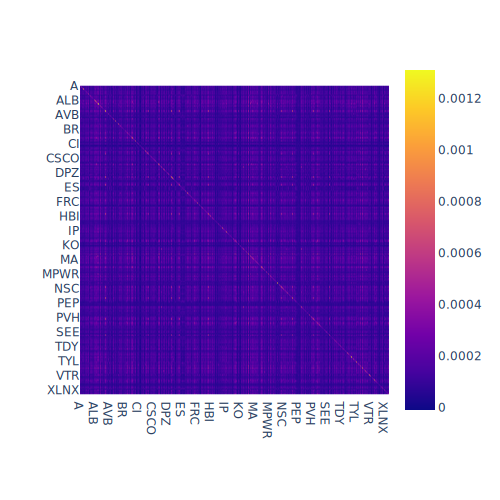

In [6]:
us_cov_log_rets = us_log_rets.cov()
cov_fig = px.imshow(us_cov_log_rets, width=500)
us_cov_log_rets.shape
cov_fig.show("svg")

### Data preprocessing

In [7]:
# Standardizing
mu, sigma = us_log_rets.mean(), us_log_rets.std()
us_log_rets_rescaled = (us_log_rets.sub(mu, axis=1)).div(sigma, axis=1)

# Train-test split
cutoff = 0.8
n = len(us_log_rets_rescaled)
X_train_raw, X_test_raw = us_log_rets[:int(n*cutoff)], us_log_rets[int(n*cutoff):]
X_train_rescaled , X_test_rescaled = us_log_rets_rescaled[:int(n*cutoff)], us_log_rets_rescaled[int(n*cutoff):]

X_train_raw.shape
X_test_raw.shape

X_train_rescaled.shape
X_test_rescaled.shape

(2076, 448)

(520, 448)

(2076, 448)

(520, 448)

### Principal Component Analysis

**Objective**: Project the data onto a lower dimensional *linear* space such that the *variance* of the projected data is *maximized*. Equivalently, it is the linear projection that *minimizes* the average projection cost (mean squared distance between data points and their projections).

### Eigenvalues and Eigenvectors

***Python Programming and Numerical Methods: A Guide for Engineers and Scientists by Qingkai Kong, Timmy Siauw, and Alexandre M.Bayen (Chapter 15)***

[We learned from the previous chapter that] matrix $A$ applied to a column vector $x$, that is $Ax$ is a *linear transformation* of $x$. There is a special *transform* in the followign form:


$$Ax = \lambda{}x$$

$A$ is an $n \times{} n$ [square] matrix, $x$ is an $n \times{} 1$ column vector ($x \ne 0$), and $\lambda{}$ is a scalar. Any $\lambda{}$ that satisfies the above equation is known as an **eigenvalue** of the matrix $A$, while the associated vector $x$ is called the **eigenvector** corresponding to $\lambda{}$.

The calculation of eigenvalues and eigenvectors in Python is fairly easy. The main built-in function in Python to solve the eigenvalue/eigenvector problem for a *square* array is the `eig` function in `numpy.linalg`.


For a covariance or correlation matrix, the *sum* of its eigenvalues equals the trace of the matrix, that is, the sum of the variances of the $n_{y}$ variables for a covariance matrix, and $n_{y}$ for a correlation matrix. The principal components are sorted by descending order of their variances, which are equal to the associated eigenvalues.

- https://v8doc.sas.com/sashtml/insight/chap40/sect3.htm

In [8]:
X_train_cov = X_train_rescaled.cov()
X_train_cov.shape
eigenvalues, eigenvectors = eig(X_train_cov)
print(f"Sum of variances (from original data): {X_train_cov.to_numpy().diagonal().sum():.4f}")
print(f"Sum of eigenvalues: {eigenvalues.sum():.4f}")

(448, 448)

Sum of variances (from original data): 338.1540
Sum of eigenvalues: 338.1540


#### Explained variance ratios

In [9]:
exp_var_ratios = eigenvalues / eigenvalues.sum()
exp_var_ratios.shape
exp_var_ratios.sum()

(448,)

1.0

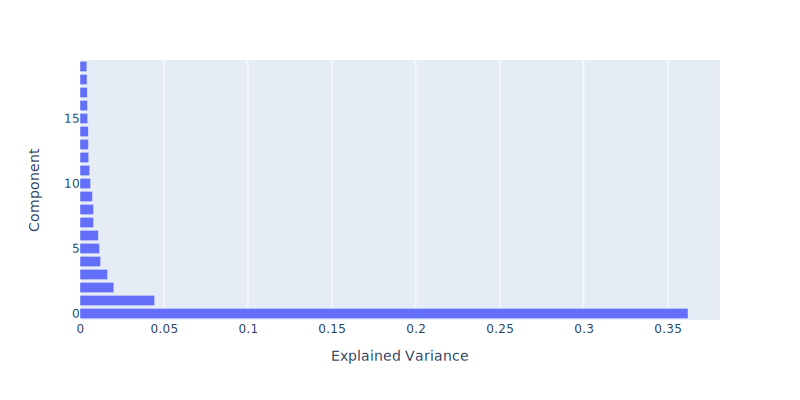

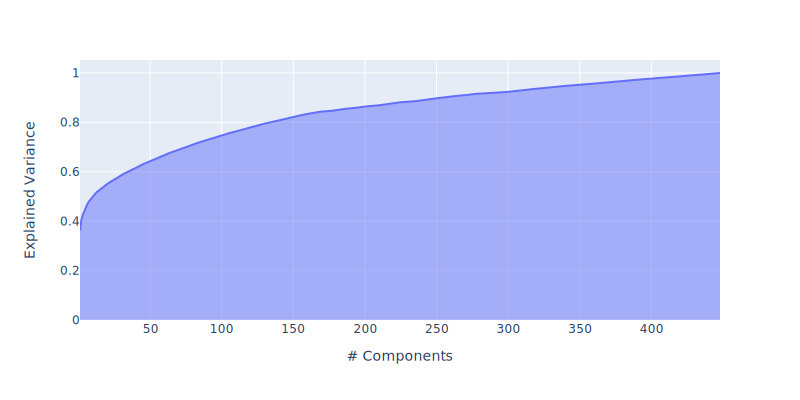

In [10]:
# Explained variace ratio by Top Factors
exp_var_ratios_fig = px.bar(x=exp_var_ratios[:20],
                            labels={"x": "Explained Variance", "y": "Component"},
                            height=400,
                            width=800)

# Explained cumulative variance
exp_var_cumul = np.cumsum(exp_var_ratios)
exp_var_cumul_fig = px.area(x=range(1, exp_var_cumul.shape[0] + 1),
                            y=exp_var_cumul,
                            labels={"x": "# Components", "y": "Explained Variance"},
                            height=400,
                            width=800)

exp_var_ratios_fig.show("svg")
exp_var_cumul_fig.show("svg")

### Eigen Portfolios

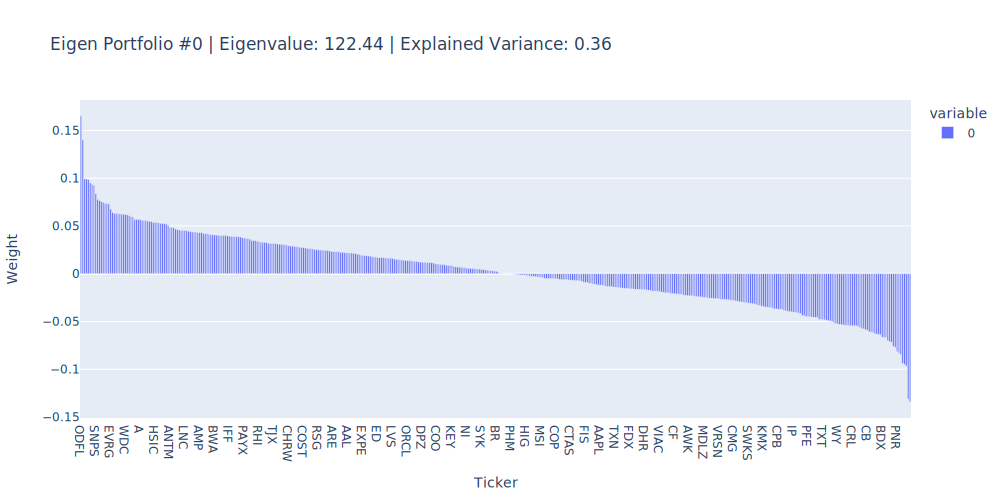

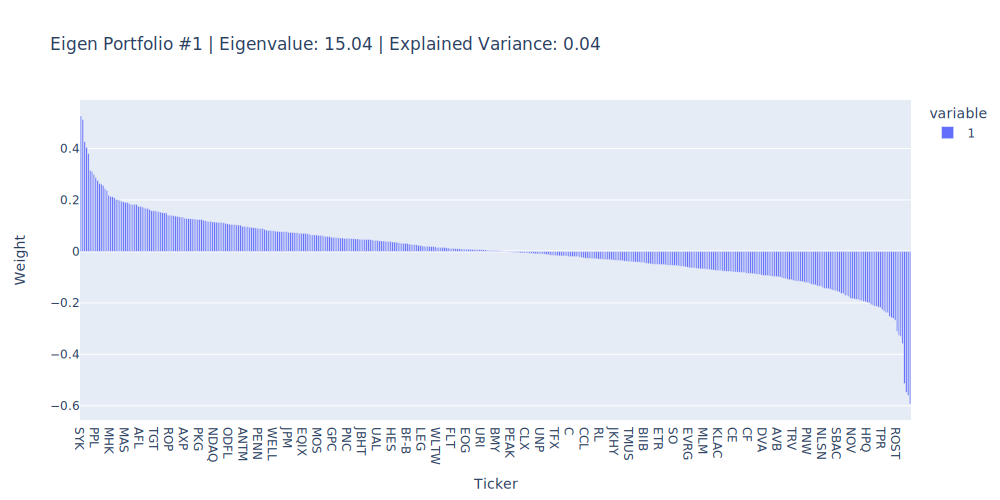

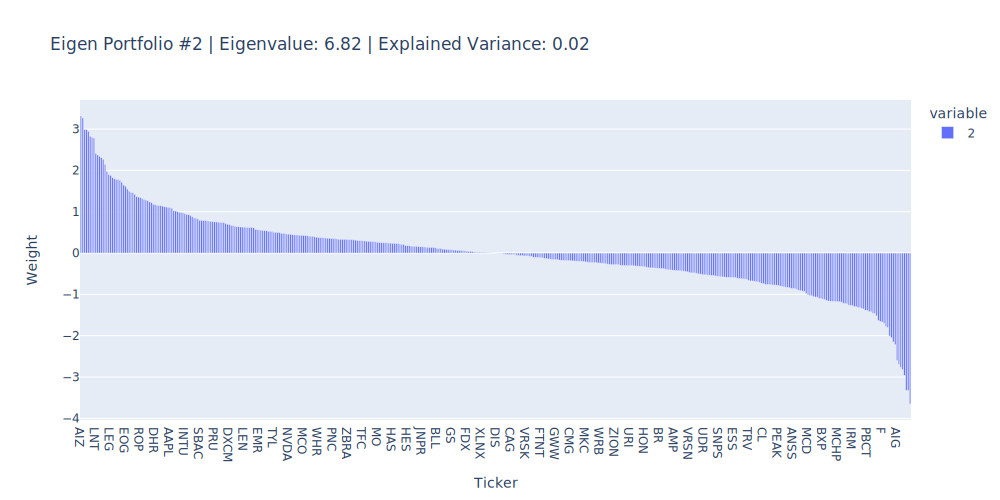

In [11]:
eigenPortfolios = list(map(lambda x: x / x.sum(), eigenvectors))
eigenPortfolios_df = pd.DataFrame(eigenPortfolios, columns=X_train_raw.columns)

for i in range(3):
    
    fig_i = px.bar(eigenPortfolios_df.iloc[i].sort_values(ascending=False).to_frame(),
                   title=f"Eigen Portfolio #{i} | Eigenvalue: {eigenvalues[i]:.2f} | Explained Variance: {exp_var_ratios[i]:.2f}",
                   labels={"index":"Ticker", "value": "Weight"},
                   width=1000,
                   height=500)
    
    fig_i.show("svg")

### Finding the best eigen portfolio

In [12]:
def get_sharpe_ratio(x):
    assert len(x.shape) == 1
    x = x.copy()
    ann_ret = x.mean() * 252
    ann_std = x.std() * np.sqrt(252)
    sr = ann_ret / ann_std
    return ann_ret, ann_std, sr

my_eigenports = {"Eigen Portfolio #" : [],
                 "Weights" : [],
                 "Return" : [],
                 "Volatility": [],
                 "Sharpe Ratio" : []}

# Compute Sharpe Ratio for every eigen portfolio
for i in range(len(eigenPortfolios_df)):
    eigenPort_i = eigenPortfolios_df.iloc[i].to_numpy()
    rets_i = np.dot(X_train_raw, eigenPort_i)
    ret, vol, sr = get_sharpe_ratio(rets_i)
    my_eigenports["Eigen Portfolio #"].append(str(i))          
    my_eigenports["Weights"].append(eigenPort_i)
    my_eigenports["Return"].append(ret)
    my_eigenports["Volatility"].append(vol)
    my_eigenports["Sharpe Ratio"].append(sr)

### Sharpe ratios

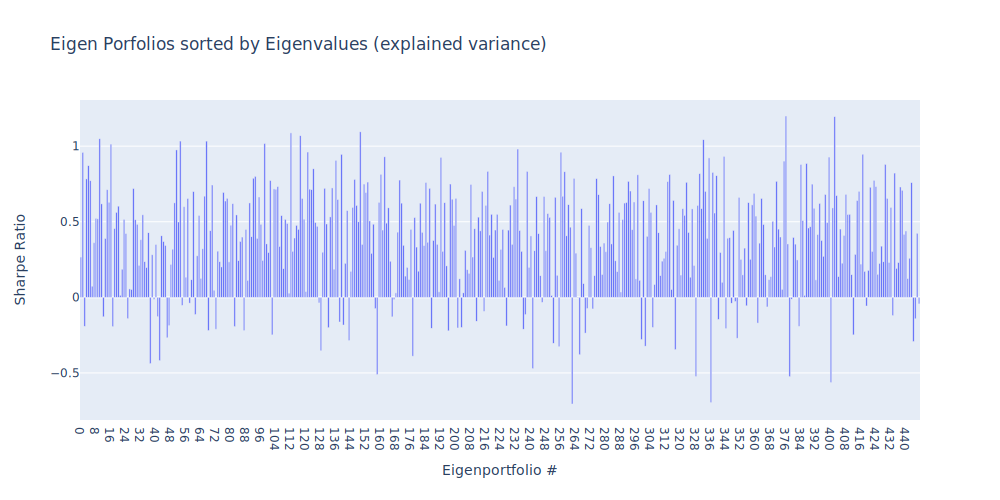

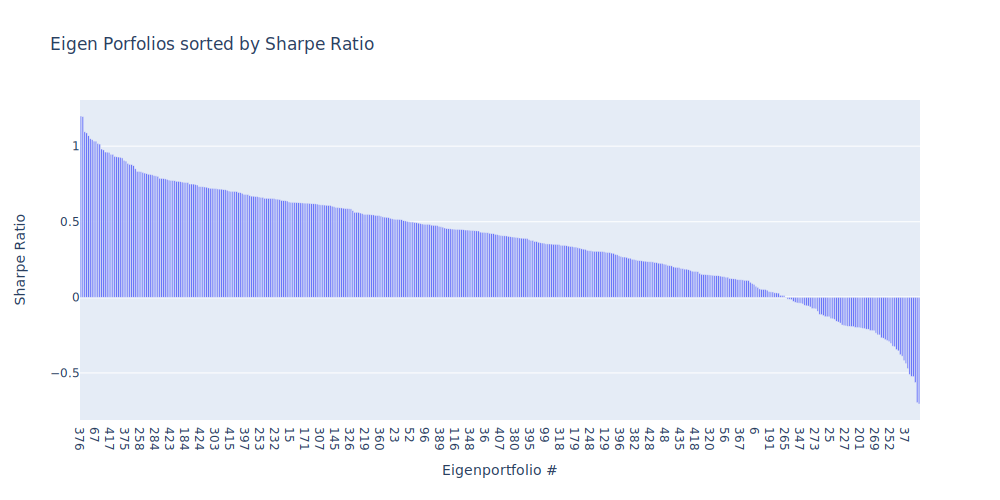

In [13]:
eigenports_sr_df = pd.DataFrame(my_eigenports["Sharpe Ratio"], columns=["Sharpe Ratio"])
eigenports_sr_sorted_df = eigenports_sr_df.sort_values(by="Sharpe Ratio", ascending=False)

eigenports_sr_fig1 = px.bar(x=list(map(str, eigenports_sr_df.index.to_numpy().squeeze())),
                            y=eigenports_sr_df.to_numpy().squeeze(),
                            labels = {"x": "Eigenportfolio #", "y": "Sharpe Ratio"},
                            title="Eigen Porfolios sorted by Eigenvalues (explained variance)",
                            width=1000,
                            height=500)

eigenports_sr_fig2 = px.bar(x=list(map(str, eigenports_sr_sorted_df.index.to_numpy().squeeze())),
                            y=eigenports_sr_sorted_df.to_numpy().squeeze(),
                            labels={"x": "Eigenportfolio #", "y": "Sharpe Ratio"},
                            title="Eigen Porfolios sorted by Sharpe Ratio",
                            width=1000,
                            height=500)

eigenports_sr_fig1.show("svg")
eigenports_sr_fig2.show("svg")

### Backtesting eigen portfolios

In [14]:
def get_eigen_rets(test_df, n_eigen_portfolios):
    
    # Copy
    test = test_df.copy()
    eigenports_sr = eigenports_sr_df.copy()
    eigenports_dict = my_eigenports.copy()
    
    # Sort by sharpe ratio
    eigenports_sr = eigenports_sr.sort_values(by="Sharpe Ratio", ascending=False)
    
    # Eigen portfolios
    eigen_ports = eigenports_sr.index[:n_eigen_portfolios]
    eigen_weights = [eigenports_dict["Weights"][i] for i in eigen_ports]
    
    # Returns
    eigen_rets = np.array(list(map(lambda n: np.dot(test, n), eigen_weights)))
    eigen_df = pd.DataFrame(eigen_rets.T, 
                            columns=list(map(str, eigen_ports)), 
                            index=test.index)

    # Equal-weighted eigen portfolio
    ew_eigen_rets = (eigen_rets.T * (1./eigen_rets.T.shape[1])).sum(axis=1)
    ew_eigen_df = pd.DataFrame(ew_eigen_rets,
                               columns=["EW-Eigen"],
                               index=test.index)
    # Equal-weighted SP500
    ew_sp_rets = (test * (1./test.shape[1])).sum(axis=1)
    ew_sp_df = pd.DataFrame(ew_sp_rets,
                            columns=["EW-SP500"],
                            index=test.index)
    
    all_eigen_df = eigen_df.join([ew_eigen_df, ew_sp_df])
    
    return all_eigen_df

def get_eigen_stats(rets_df):
    
    rets_df = rets_df.copy()
    
    # Compute sharpe ratio
    sr = np.array(rets_df.apply(get_sharpe_ratio, axis=0).T)
    
    stats = pd.DataFrame(data=sr,
                         columns=["Return", "Volatility", "SR"],
                         index=rets_df.columns).sort_values(by="SR", ascending=False)
    return stats

### Train

,Return,Volatility,SR
EW-Eigen,0.255168,0.148371,1.719790
376,0.481097,0.401226,1.199069
402,0.272760,0.228387,1.194288
149,0.251038,0.229439,1.094138
112,0.171372,0.157634,1.087156


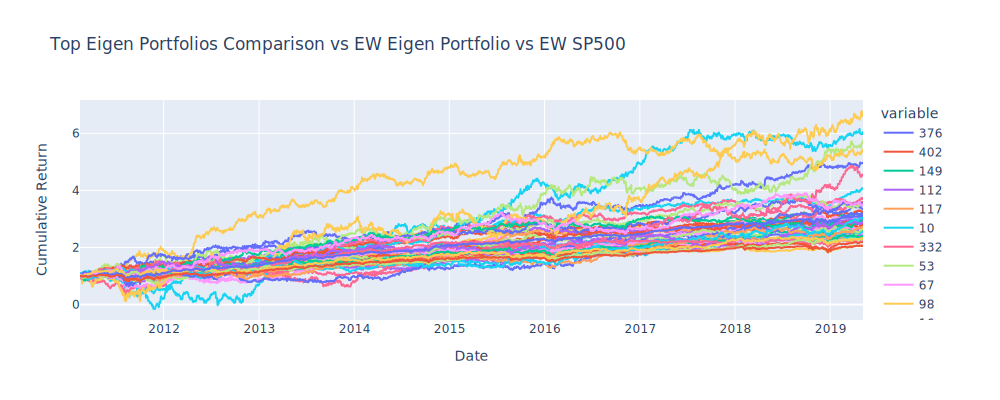

,Return,Volatility,SR
EW-Eigen,0.255168,0.148371,1.719790
EW-SP500,0.126896,0.152291,0.833247


In [18]:
eigen_train_rets = get_eigen_rets(test_df=X_train_raw, 
                                  n_eigen_portfolios=50)

# Sharpe Ratios
eigen_train_sr = get_eigen_stats(eigen_train_rets)
eigen_train_sr.head(5)

# Cumulative Returns
eigen_train_fig = px.line(1. + eigen_train_rets.cumsum(),
                          labels={"value" : "Cumulative Return"},
                          title=f"Top Eigen Portfolios Comparison vs EW Eigen Portfolio vs EW SP500",
                          width=1000,
                          height=400)

eigen_train_fig.show("svg")
eigen_train_sr.loc[["EW-Eigen", "EW-SP500"]]

### Test

,Return,Volatility,SR
258,0.572617,0.436309,1.312410
149,0.417989,0.321341,1.300767
238,0.543949,0.449030,1.211386
4,0.415426,0.344907,1.204459
92,0.391557,0.326114,1.200676


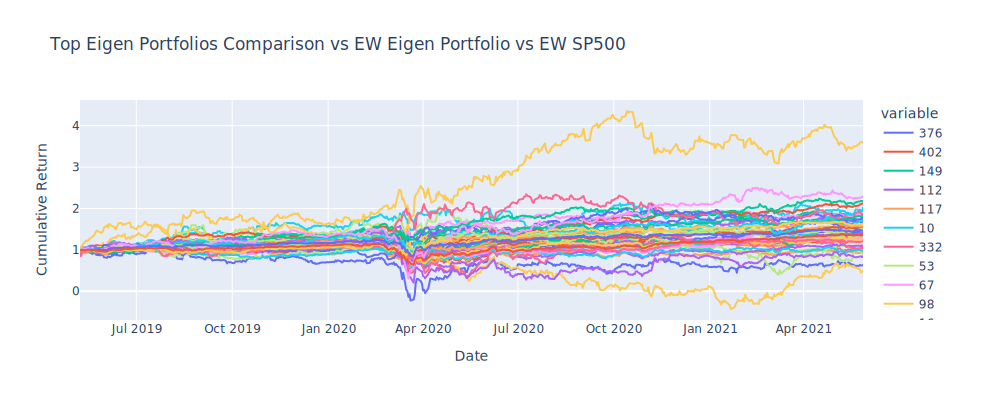

,Return,Volatility,SR
EW-Eigen,0.228384,0.256626,0.889950
EW-SP500,0.176463,0.285187,0.618764


In [17]:
eigen_test_rets = get_eigen_rets(test_df=X_test_raw, 
                                 n_eigen_portfolios=50)

# Sharpe ratios
eigen_test_sr = get_eigen_stats(eigen_test_rets)
eigen_test_sr.head(5)

# Cumualtive returns
eigen_test_fig = px.line(1. + eigen_test_rets.cumsum(),
                         labels={"value" : "Cumulative Return"},
                         title=f"Top Eigen Portfolios Comparison vs EW Eigen Portfolio vs EW SP500",
                         width=1000,
                         height=400)

eigen_test_fig.show("svg")
eigen_test_sr.loc[["EW-Eigen", "EW-SP500"]]